In [ ]:
using  Plots, Optim, Dates, DiffEqParamEstim, Flux, DiffEqFlux, OrdinaryDiffEq, MAT, Statistics, LinearAlgebra

In [ ]:
# siControl B55=1.0, MASTL=1.0
CCNB1 = [0.06864988558352358 1.0000073226544623;
10 0.7727963386727688;
14.988558352402745 0.5271945080091531;
16.95652173913043 0.44110938215102957;
18.970251716247137 0.2718315789473681;
20.892448512585815 0.26893913043478235;
22.906178489702516 0.18446132723112085;
24.82837528604119 0.1031688787185352;
26.979405034324945 0.0763130434782604;
28.993135011441648 0.05263524027459909;
30.961098398169337 0.046550114416475497;
33.02059496567506 0.037279633867276285;
34.98855835240275 0.021594508009152857;
37.00228832951946 0.034716704805491494;
39.016018306636155 0.0270389016018302;
40.93821510297482 0.028946453089244484;
42.951945080091534 0.03246864988558307;
45.01144164759725 0.024798169336383902
]

pMPS1 = [0.06864988558352358 0.9536073226544624;
10.045766590389015 0.9920036613272312;
14.94279176201373 0.8951871853546911;
16.95652173913043 0.8971093821510296;
19.016018306636155 0.9214389016018305;
20.93821510297483 0.9233464530892447;
22.906178489702516 0.802061327231121;
25.05720823798627 0.7816054919908465;
27.02517162471396 0.7627203661327229;
28.993135011441648 0.8014352402745993;
30.961098398169337 0.7041501144164757;
32.97482837528604 0.7972723112128144;
34.94279176201373 0.7047871853546908;
36.95652173913044 0.6267093821510294;
38.970251716247134 0.5614315789473681;
41.029748283752866 0.542561098398169;
42.951945080091534 0.49646864988558315;
44.965675057208244 0.4631908466819218;
]

pENSA = [-0.022883295194509046 0.7231926773455378;
9.86270022883295 0.7567743707093821;
14.988558352402745 0.7415945080091532;
17.048054919908463 0.719524027459954;
18.924485125858123 0.715024256292906;
20.983981693363848 0.6481537757437068;
22.99771167048055 0.6708759725400456;
25.011441647597255 0.5927981693363842;
26.88787185354691 0.513098398169336;
28.855835240274597 0.5230132723112124;
31.006864988558352 0.4369574370709378;
32.92906178489703 0.381264988558352;
34.98855835240275 0.27759450800915275;
36.95652173913044 0.2603093821510294;
39.06178489702518 0.14704622425629243;
41.029748283752866 0.123361098398169;
42.906178489702526 0.08046132723112076;
44.965675057208244 0.07919084668192156
];

In [ ]:
a = CCNB1[:,2]
b = pMPS1[:,2]
c = pENSA[:,2]

plt=plot(a,b,c, xlab = "CCNB1", ylab = "pMPS1", zlab  = "pENSA", grid = "off", legend= :bottomright)
scatter!(a,b,c)

In [4]:
# Observed data
ode_data = transpose(hcat( a,b,c))
u0 = ode_data[:,1]
tspan = (0.,1.)
if(CCNB1[1]>0)
    t = CCNB1[:,1].-(CCNB1[1])
else
    t = CCNB1[:,1].+abs(CCNB1[1])
end
t = t./t[end]
species = ["CCNB1", "pMPS1", "pENSA"];u0

3-element Array{Float64,1}:
 1.0000073226544623
 0.9536073226544624
 0.7231926773455378

In [5]:
mutable struct saver
    losses::Array{Float64,1}
    l2s::Array{Float64,1}
    times::Array{Dates.Time,1}
    count_epochs::Int128
end
function saver(n_epochs)
    losses = zeros(n_epochs)
    l2s = zeros(n_epochs)
    times = fill(Dates.Time(Dates.now()), n_epochs)
    count_epochs = 0
    return saver(losses, l2s, times, count_epochs)
end
function update_saver(saver, loss_i, l2_i, time_i)
    epoch_i = saver.count_epochs
    saver.losses[epoch_i] = loss_i
    saver.l2s[epoch_i] = l2_i
    saver.times[epoch_i] = time_i
end

update_saver (generic function with 1 method)

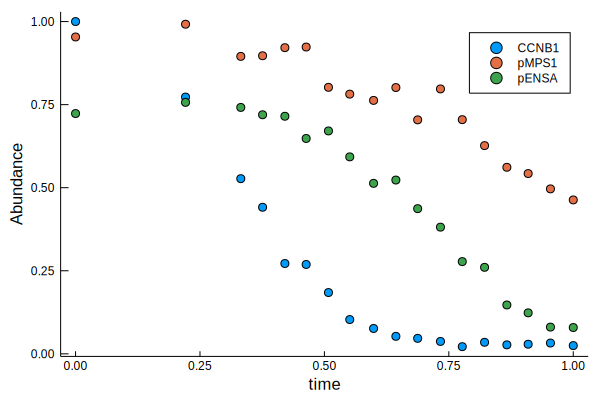

In [6]:

scatter(t, ode_data[1,:], grid = "off", xlab = "time", ylab = "Abundance", label = species[1])
#plot!(t, ode_data[1,:], label = species[1])

scatter!(t, ode_data[2,:], grid = "off", xlab = "time", ylab = "Abundance", label = species[2])
#plot!(t, ode_data[2,:], grid = "off", xlab = "time", ylab = "Abundance", label = species[2])

scatter!(t, ode_data[3,:], grid = "off", xlab = "time", ylab = "Abundance", label = species[3])
#plot!(t, ode_data[3,:], grid = "off", xlab = "time", ylab = "Abundance", label = species[3])


In [ ]:
# Building a neural ODE 
# Derivative is modeled by a neural net. Chain concatinates the functions ode function and two dense layers.
dudt = Chain(Dense(3,80,tanh),
       Dense(80,80,tanh),
       Dense(80,80,tanh),
       Dense(80,3))
# Parameters of the model which are to be learnt. They are: W1 (2x50), b1 (50), W2 (50x2), b2 (2)
ps = Flux.params(dudt)
# Getting loss function from two stage collocation function
function node_two_stage_function(model, x, tspan, saveat, ode_data,
            args...; kwargs...)
  dudt_(du,u,p,t) = du .= model(u)
  prob_fly = ODEProblem(dudt_,x,tspan)
  two_stage_method(prob_fly, saveat, ode_data)
end
# Rosenbrock23, TRBDF2, ABDF2, Rodas5, Rodas4P, Kvaerno5, KenCarp4, CVODE_BDF (not defined)
loss_n_ode = node_two_stage_function(dudt, u0, tspan, t, ode_data, Rosenbrock23(autodiff=false), reltol=1e-7, abstol=1e-9)
#  loss function
two_stage_loss_fct()=loss_n_ode.cost_function(ps)
# Defining anonymous function for the neural ODE with the model. in: u0, out: solution with current params.
n_ode = x->neural_ode(dudt, x, tspan, Rosenbrock23(autodiff=false), saveat=t, reltol=1e-7, abstol=1e-9)
n_epochs = 5000
verify = 10 # for <verify>th epoch the L2 is calculated  
data1 = Iterators.repeated((), n_epochs)
opt1 = ADAM(0.0001)

L2_loss_fct() = sum(abs2,ode_data .- n_ode(u0))
# Callback function to observe two stage training.
cb1 = function ()
    sa.count_epochs = sa.count_epochs +  1
    if mod(sa.count_epochs-1, verify)==0
        update_saver(sa, Tracker.data(two_stage_loss_fct()), Tracker.data(L2_loss_fct()), Dates.Time(Dates.now()))
        # println("\"",Tracker.data(two_stage_loss_fct()),"\" \"",Dates.Time(Dates.now()),"\";")
    else
        update_saver(sa, Tracker.data(two_stage_loss_fct()),0, Dates.Time(Dates.now()))
        # println("\"",Tracker.data(two_stage_loss_fct()),"\" \"",Dates.Time(Dates.now()),"\";")
    end
end

In [ ]:
pred = n_ode(u0)
#scatter(t, ode_data[1,:], label = string("Observation: ", species1), grid = "off")
scatter(t, ode_data[1,:], label = string("Observation: ", species[1]), grid = "off", ylim=[0,1.3])
scatter!(t, ode_data[2,:], label = string("Observation: ", species[2]))
scatter!(t, ode_data[3,:], label = string("Observation: ", species[3]))
#plot!(t, Flux.data(pred[1,:]), label = string("Prediction: ", species1))
plot!(t, Flux.data(pred[1,:]), label = string("Prediction: ", species[1]))
plot!(t, Flux.data(pred[2,:]), label = string("Prediction: ", species[2]))
plot!(t, Flux.data(pred[3,:]), label = string("Prediction: ", species[3]))

In [ ]:
sa = saver(n_epochs)
# train n_ode with collocation method
@time Flux.train!(two_stage_loss_fct, ps, data1, opt1, cb = cb1)

In [ ]:
pred = n_ode(u0)
#scatter(t, ode_data[1,:], label = string("Observation: ", species1), grid = "off")
scatter(t, ode_data[1,:], label = string("Observation: ", species[1]), grid = "off", ylim=[0,1.3])
scatter!(t, ode_data[2,:], label = string("Observation: ", species[2]))
scatter!(t, ode_data[3,:], label = string("Observation: ", species[3]))
#plot!(t, Flux.data(pred[1,:]), label = string("Prediction: ", species1))
plot!(t, Flux.data(pred[1,:]), label = string("Prediction: ", species[1]))
plot!(t, Flux.data(pred[2,:]), label = string("Prediction: ", species[2]))
plot!(t, Flux.data(pred[3,:]), label = string("Prediction: ", species[3]))

In [ ]:
header = string("Collocation model")
scatter(range(1, stop = length(sa.l2s)), log.(sa.l2s), width  = 2, label = "L2 control", grid = "off")
plot!(range(1, stop = length(sa.losses)), log.(sa.losses), width  = 2, label = header)
# 5% of time even with l2s

In [ ]:
# train n_ode with collocation method
sa = saver(n_epochs)
@time Flux.train!(two_stage_loss_fct, ps, data1, opt1, cb = cb1)

In [ ]:
pred = n_ode(u0)
#scatter(t, ode_data[1,:], label = string("Observation: ", species1), grid = "off")
scatter(t, ode_data[1,:], label = string("Observation: ", species[1]), grid = "off", ylim=[0,1.3])
scatter!(t, ode_data[2,:], label = string("Observation: ", species[2]))
scatter!(t, ode_data[3,:], label = string("Observation: ", species[3]))
#plot!(t, Flux.data(pred[1,:]), label = string("Prediction: ", species1))
plot!(t, Flux.data(pred[1,:]), label = string("Prediction: ", species[1]))
plot!(t, Flux.data(pred[2,:]), label = string("Prediction: ", species[2]))
plot!(t, Flux.data(pred[3,:]), label = string("Prediction: ", species[3]))

In [ ]:
header = string("Collocation model")
scatter(range(1, stop = length(sa.l2s)), log.(sa.l2s), width  = 2, label = "L2 control", grid = "off")
plot!(range(1, stop = length(sa.losses)), log.(sa.losses), width  = 2, label = header)
# 5% of time even with l2s